In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


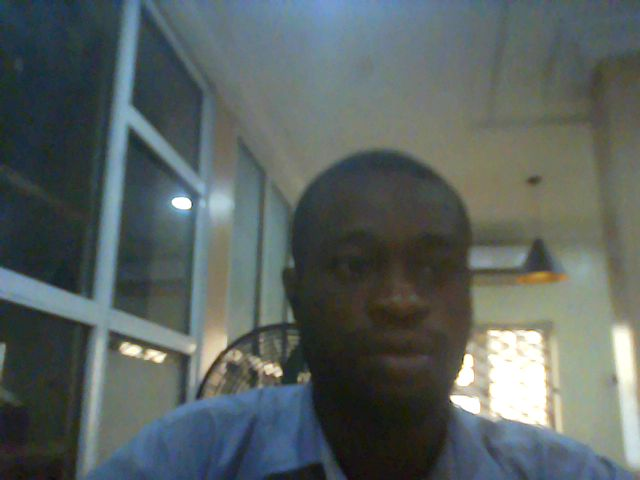

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import numpy as np
import cv2
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.models import load_model
from os import listdir
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
faceCascade= cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
def preprocess_image(img_path):
    img = image.load_image(img_path, target_size(224, 224))
    img = image_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
age_model = load_model('/content/drive/MyDrive/Colab Notebooks/models/age_model.h5')
gender_model = load_model('/content/drive/MyDrive/Colab Notebooks/models/gender_model.h5')

In [ ]:
# indices for age labels
output_indices = np.array(range(101))

In [ ]:
gender_labels = ['Female', 'Male']

In [ ]:
enableGenderIcons = False

# male_icon = cv2.imread("male.jpg")
# male_icon = cv2.resize(male_icon, (40, 40))

# female_icon = cv2.imread("female.jpg")
# female_icon = cv2.resize(female_icon, (40, 40))

In [ ]:
video_capture = cv2.VideoCapture(0)  # capture front camera(0)

while True:
    ret, frame =  filename                             #video_capture.read()
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(img_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        if w > 130:    # ignore small faces
            cv2.rectangle(frame, (x,y), (x+w, y+h), (128, 128, 128), 1) # draw rectangle on main image
            detected_face = frame[int(y): int(y+h), int(x): int(x+w)] # crop detected face

            try:
                # expand detected face to accomodate margin
                margin = 30
                margin_x = int((w * margin)/100); margin_y = int((h * margin)/ 100)
                detected_face = frame[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]

            except:
                print('detected face has no image')

            # resizing image to expected size
            try:

                # resizing image to expected size
                detected_face = cv2.resize(detected_face, (224,224))

                img_pixels = img_to_array(detected_face)
                img_pixels = np.expand_dims(img_pixels, axis=0)
                img_pixels /= 255

                # predict age
                age_prediction = age_model.predict(img_pixels)
                apparent_age = str(int(np.floor(np.sum(age_prediction * output_indices, axis = 1))[0]))

                # predict gender
                gender_prediction = gender_model.predict(img_pixels)
                gender_index = np.argmax(gender_prediction)
                gender = gender_labels[gender_index]


                # back ground to display age and gender
                info_box_color = (46, 200, 255)
                triangle_cnt = np.array( [(x+int(w/2), y), (x+int(w/2)-20, y-20), (x+int(w/2)+20, y-20)] )
                cv2.drawContours(frame, [triangle_cnt], 0, info_box_color, -1)
                cv2.rectangle(frame,(x+int(w/2)-50,y-20),(x+int(w/2)+50,y-90),info_box_color,cv2.FILLED)

                # labels for age and gender
                cv2.putText(frame, apparent_age, (x+int(w/2), y - 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 111, 255), 2)

                if enableGenderIcons:
                    if gender == 'Male': gender_icon = male_icon
                    else: gender_icon = female_icon

                else:
                    cv2.putText(frame, gender, (x+int(w/2)-20, y - 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 111, 255), 2)

            except Exception as e:
                print("exception: ",str(e))

    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit webcam
        break


# close opencv
video_capture.release()
cv2.destroyAllWindows()

error: ignored